In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print("cuda would be available, but not set")
    # torch.set_default_device('cuda')
else:
    print("cuda is not available")
if torch.backends.mps.is_available():
    print("mps would be available, but not set")
    mps_device = torch.device("mps")

cuda is not available
mps would be available, but not set


## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
# training_data.data = training_data.data.to('cuda')
# training_data.targets = training_data.targets.to('cuda')
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# test_data.data = test_data.data.to('cuda')
# test_data.targets = test_data.targets.to('cuda')
# print('Moved to GPU')

In [4]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

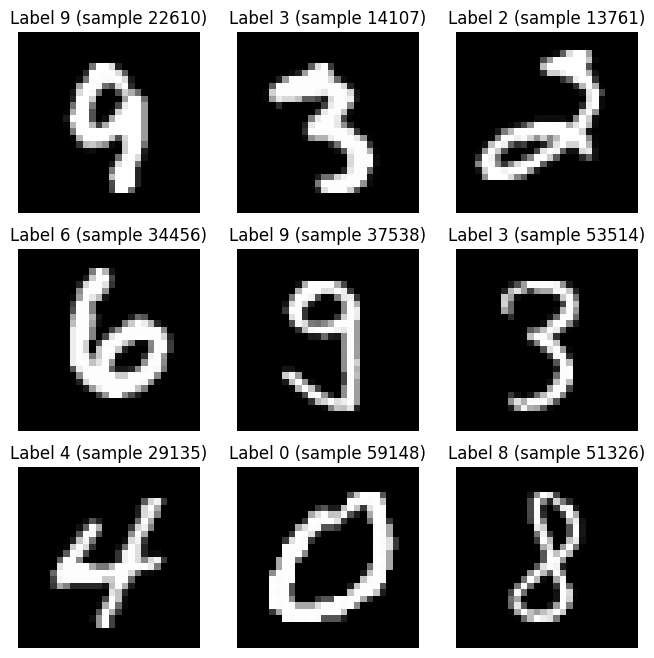

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)" % (label, sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [7]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [8]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


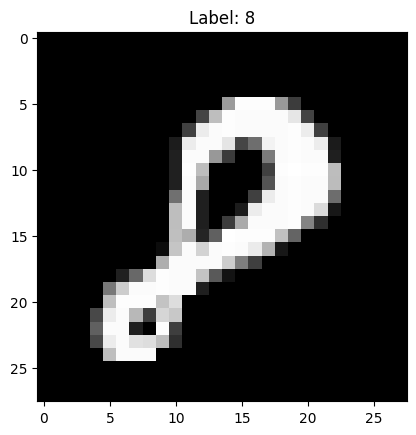

In [9]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [10]:


def linear_trsf(x, W, b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    batch_size = x.shape[0]
    x1 = x.view(batch_size, -1)
    return x1 @ W.T + b


def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    s = torch.exp(z)
    return s / torch.sum(s, dim=1, keepdim=True)


def predict(x, W, b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    return softmax(linear_trsf(x, W, b))


##### TEST

In [11]:
W, b = torch.randn((10, 28 * 28)), torch.zeros((1, 10))
print(W.shape, b.shape)
u = predict(x, W, b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 0.9999998807907104


#### Loss Function

In [12]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    batch_size = y.shape[0]
    return -torch.log(uhat[torch.arange(batch_size), y[:]])


def cost_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    x = torch.mean(loss_ce(y, uhat))
    return x


#### Accuracy

In [13]:
def accuracy(Y, yhat):
    predicted_labels = torch.argmax(yhat, dim=1)
    correct_predictions = (predicted_labels == Y).float().sum().item()

    return correct_predictions / Y.shape[0]

##### TEST

In [14]:
y = torch.tensor([0, 2])
z = torch.tensor([[1., 2, 3], [2, 2, 2]]).reshape(-1, 3)
uhat = softmax(z)
print(loss_ce(y, uhat), cost_ce(y, uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [15]:
def grad_loss_ce(x, u, uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    gradW = torch.mean((uhat - u).view(-1, 10, 1) * x.view(-1, 1, 28 * 28), dim=0)
    gradb = torch.mean((uhat - u), dim=0)
    return gradW, gradb

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [16]:
def metrics(X, Y, W, b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)
    
    return -- cost, acc (both scalars)
    """
    pred = predict(X, W, b)
    cost = cost_ce(Y, pred)
    acc = accuracy(Y, pred)
    return cost, acc

#### Training

In [17]:
def learn_and_plot_results(number_epochs, learning_rate, batch_size, log_pre_epoch=False):
    nclasses = 10
    num_batches = len(training_data) / float(batch_size)
    # data loader
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
    Xtrain, Ytrain = next(iter(DataLoader(training_data, batch_size=60000)))

    # test data - we can load all samples for the test since it easily fits into memory
    Xtest, Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True)))
    

    cost_hist = []
    acc_hist = []
    cost_hist_test = []
    acc_hist_test = []
    # initial parameters
    W, b = torch.randn((10, 28 * 28)), torch.zeros((1, 10))

    d0 = datetime.now()

    print("Epoch:", end=' ')

    for epoch in range(1, number_epochs + 1):
        print(epoch, end=' ,')
        cost = 0.0
        acc = 0
        for X, Y in train_dataloader:
            yhat = predict(X, W, b)
            u = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses)).float()
            dw, db = grad_loss_ce(X, u, yhat)
            W = W - learning_rate * dw
            b = b - learning_rate * db

        pred = predict(Xtrain, W, b)
        cost = cost_ce(Ytrain, pred)
        cost_hist.append(cost.squeeze().item())
        acc = accuracy(Ytrain, pred)
        acc_hist.append(acc)

        ypred = predict(Xtest, W, b)
        cost_test = cost_ce(Ytest, ypred)
        cost_hist_test.append(cost_test.squeeze().item())
        acc_test = accuracy(Ytest, ypred)
        acc_hist_test.append(acc_test)

        if log_pre_epoch:
            print("Epoch %i: train cost: %f, train acc: %f, test cost: %f, test acc: %f" % (
                epoch, cost, acc, cost_test, acc_test))

    d = datetime.now()
    print("Train duration per epoch: ", (d - d0).total_seconds() / number_epochs)

    plt.figure(1, figsize=(10,5))
    plt.plot(torch.arange(1, number_epochs + 1), cost_hist, label="Train cost")
    plt.plot(torch.arange(1, number_epochs + 1), cost_hist_test, label="Test cost")
    plt.xlabel("Epoch")
    plt.xticks(torch.arange(1, number_epochs + 1))
    # plt.ylim(0, 1)
    plt.legend()
    plt.title("Cross-Entropy Cost")

    plt.figure(2, figsize=(10,5))
    plt.plot(torch.arange(1, number_epochs + 1), acc_hist, label="Train accuracy")
    plt.plot(torch.arange(1, number_epochs + 1), acc_hist_test, label="Test accuracy")
    plt.xlabel("Epoch")
    plt.xlim(1, number_epochs)
    plt.xticks(torch.arange(1, number_epochs + 1))
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Accuracy")


### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

With the following parameters and a learning rate of 0.2 and a batch size of 6000 (which in this case is a full batch gradient descent) allows the model to learn well. 

Epoch: 1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,51 ,52 ,53 ,54 ,55 ,56 ,57 ,58 ,59 ,60 ,61 ,62 ,63 ,64 ,65 ,66 ,67 ,68 ,69 ,70 ,Train duration per epoch:  1.4711203571428573


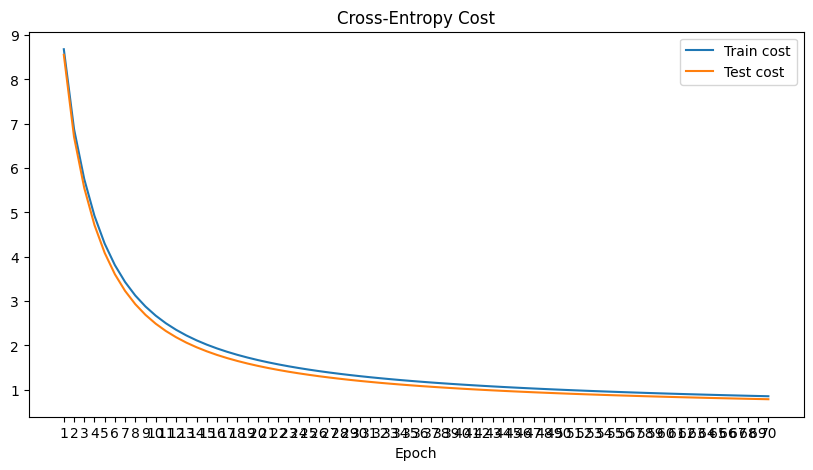

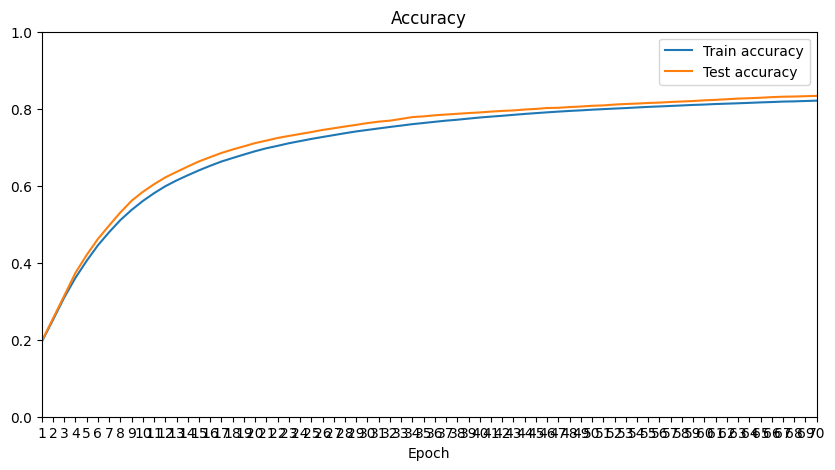

In [18]:
# Full batch gradient descent
learn_and_plot_results(number_epochs=70, learning_rate=0.2, batch_size=6000)

With a batch size of 64 in every epoch the weights get adjusted around 93 times per epoch. So the model learns much faster after fewer epochs.
Here the learning rate was reduced to lower learn slower over the mini-batches and epochs.

Epoch: 1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,Train duration per epoch:  1.1672556333333333


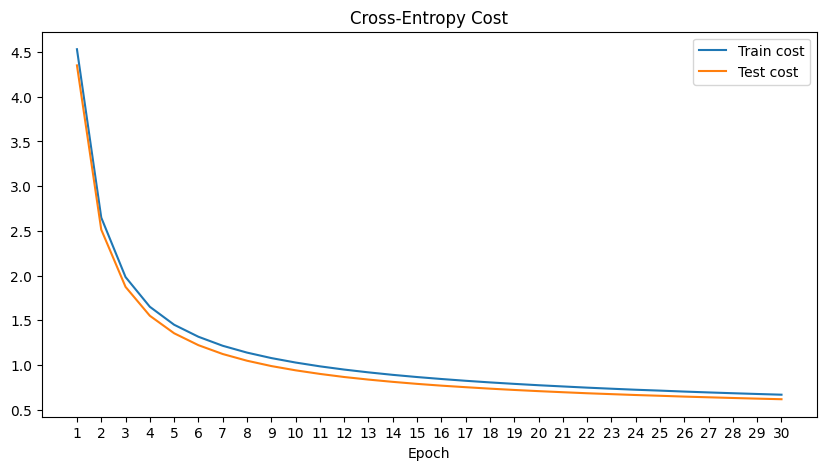

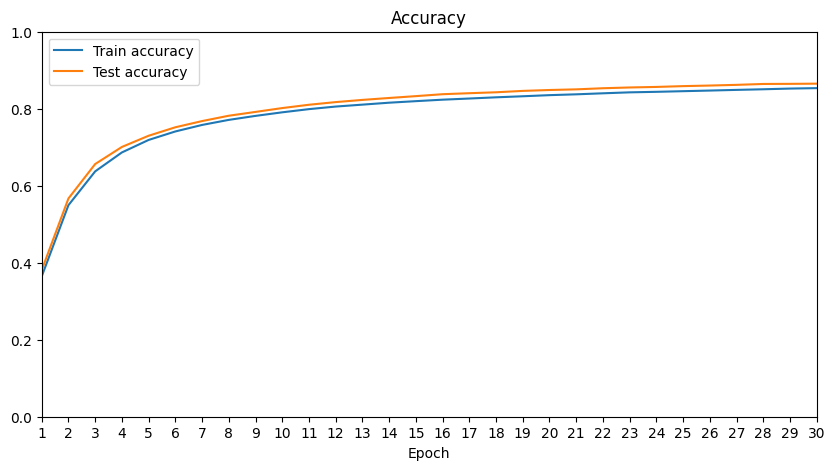

In [19]:
# SGD
learn_and_plot_results(number_epochs=30, learning_rate=0.01, batch_size=64)

Here the batch size was doubled and we see that it takes longer, till the accuracy of the model increases.

Epoch: 1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,Train duration per epoch:  1.1480587999999998


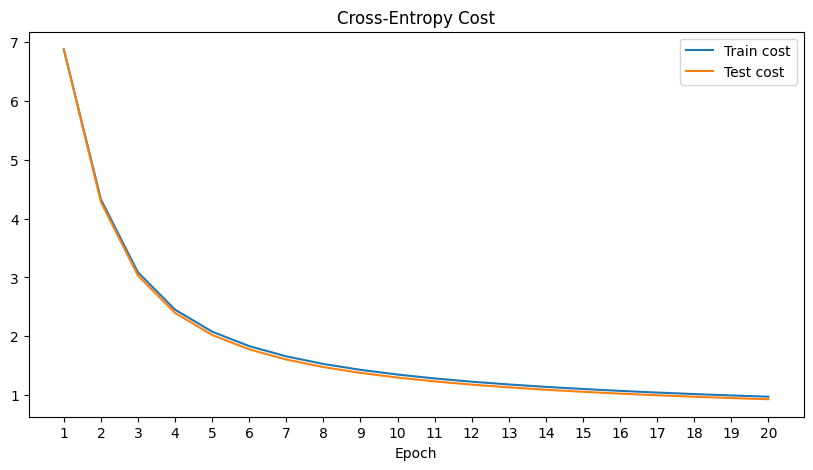

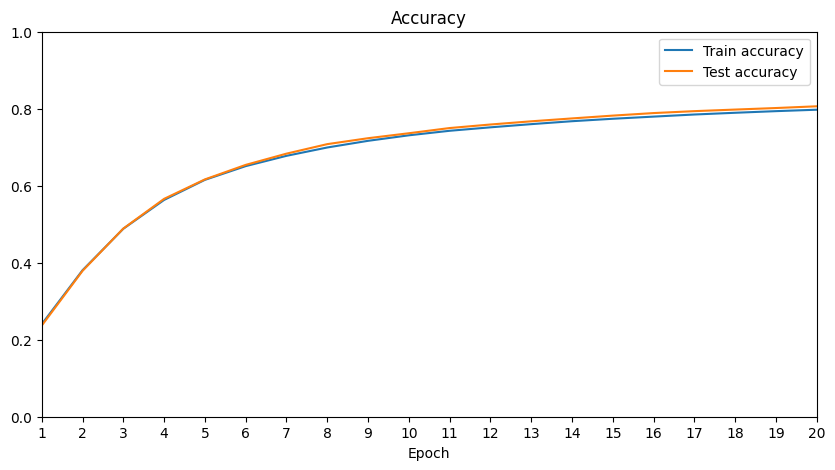

In [20]:
learn_and_plot_results(number_epochs=20, learning_rate=0.01, batch_size=128)

Here the batch size is again bigger so the learning rate was increased.
With a batch size of 1024 the weights are approx. adjusted 6 times per epoch.

Epoch: 1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,Train duration per epoch:  1.1004208


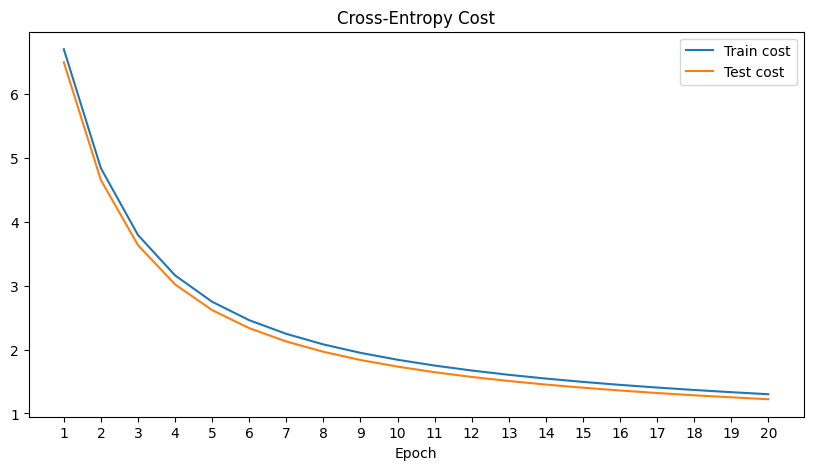

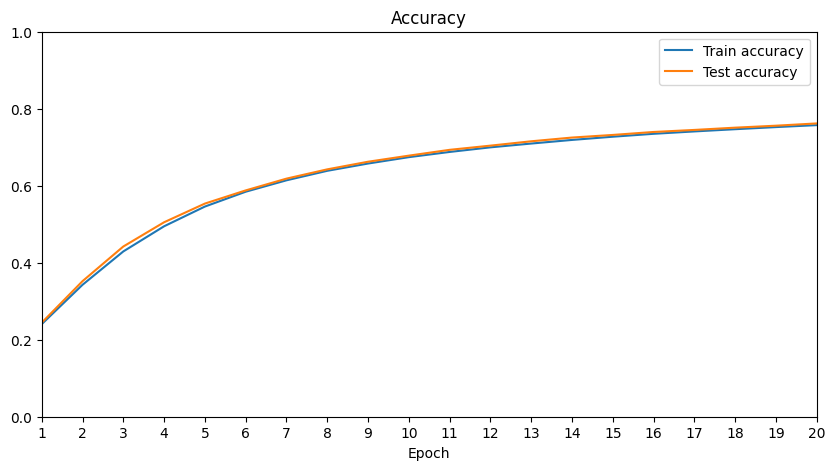

In [21]:
learn_and_plot_results(number_epochs=20, learning_rate=0.05, batch_size=1024)

Here the batch size is doubled compared to the previous example. Therefore I increased the learning rate by two fold.

Epoch: 1 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,12 ,13 ,14 ,15 ,16 ,17 ,18 ,19 ,20 ,21 ,22 ,23 ,24 ,25 ,26 ,27 ,28 ,29 ,30 ,31 ,32 ,33 ,34 ,35 ,36 ,37 ,38 ,39 ,40 ,41 ,42 ,43 ,44 ,45 ,46 ,47 ,48 ,49 ,50 ,Train duration per epoch:  1.10960462


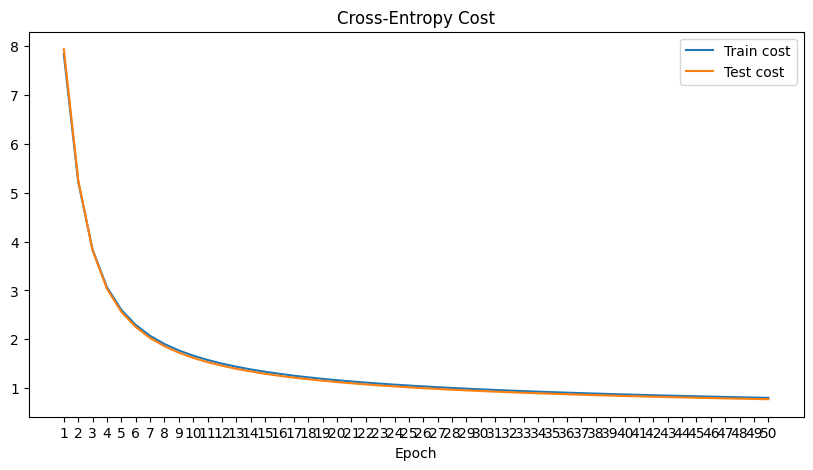

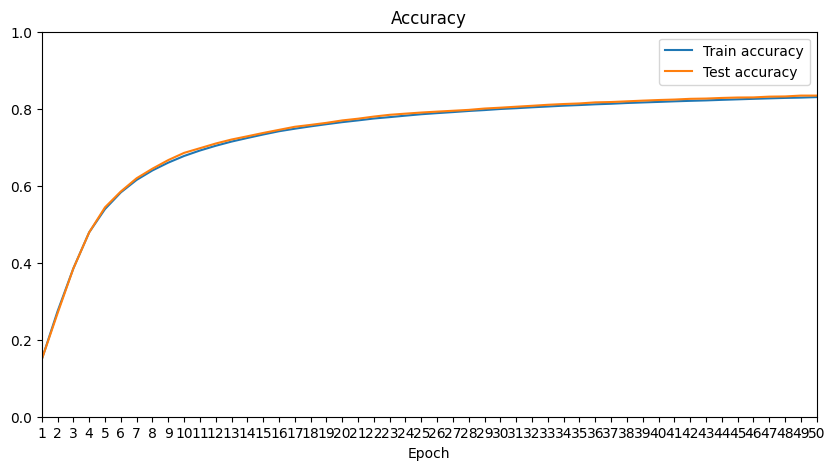

In [22]:
learn_and_plot_results(number_epochs=50, learning_rate=0.1, batch_size=2048)

### 5. With Full-Fledge PyTorch

In [23]:
class NeuralNetwork(torch.nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):  # use just one linear layer and pytorch's CrossEntropyLoss
       return self.linear(self.flatten(x))

In [24]:
model = NeuralNetwork()

In [25]:
summary(model, (1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [26]:
model = NeuralNetwork()

nbatch = 64
nepochs = 75
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
size = len(training_loader.dataset)
nbatches = len(training_loader)
training_loader_full_batch = DataLoader(training_data, batch_size=size)

for epoch in range(1,nepochs+1):
    cost, acc = 0.0, 0.0
    i = 0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = cost_ce(pred, Y)
        
        # gradient, parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for (X, Y) in training_loader_full_batch:
        pred = model(X)
        loss = cost_ce(pred, Y)
        cost_hist.append(loss.item())
        acc_hist.append((pred.argmax(dim=1) == Y).type(torch.float).sum().item() / X.shape[0])
        
    with torch.no_grad():
        for X, Y in test_loader:
            pred = model(X)
            cost_test = cost_ce(pred, Y).item()
            acc_test = (pred.argmax(dim=1) == Y).type(torch.float).sum().item() / len(test_loader.dataset)
            cost_hist_test.append(cost_test)
            acc_hist_test.append(acc_test)

    print("Epoch %i: Test cost: %f, Test acc: %f" % (epoch, cost_test, acc_test))

Epoch 1: Test cost: 0.599563, Test acc: 0.869000
Epoch 2: Test cost: 0.476398, Test acc: 0.884200
Epoch 3: Test cost: 0.425541, Test acc: 0.889900
Epoch 4: Test cost: 0.397285, Test acc: 0.895600
Epoch 5: Test cost: 0.379024, Test acc: 0.899200
Epoch 6: Test cost: 0.365257, Test acc: 0.902300
Epoch 7: Test cost: 0.355406, Test acc: 0.905500
Epoch 8: Test cost: 0.346689, Test acc: 0.906000
Epoch 9: Test cost: 0.339973, Test acc: 0.907400
Epoch 10: Test cost: 0.334623, Test acc: 0.909000
Epoch 11: Test cost: 0.329850, Test acc: 0.910000
Epoch 12: Test cost: 0.325413, Test acc: 0.911700
Epoch 13: Test cost: 0.321901, Test acc: 0.912000
Epoch 14: Test cost: 0.318562, Test acc: 0.913500
Epoch 15: Test cost: 0.315959, Test acc: 0.914500
Epoch 16: Test cost: 0.313437, Test acc: 0.915300
Epoch 17: Test cost: 0.311225, Test acc: 0.915900
Epoch 18: Test cost: 0.309308, Test acc: 0.916700
Epoch 19: Test cost: 0.306821, Test acc: 0.916100
Epoch 20: Test cost: 0.305363, Test acc: 0.916300
Epoch 21:

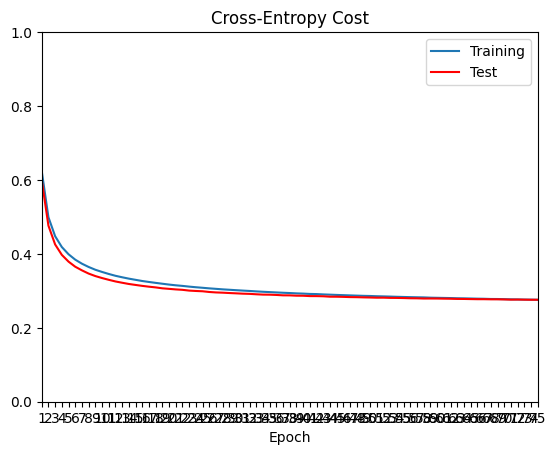

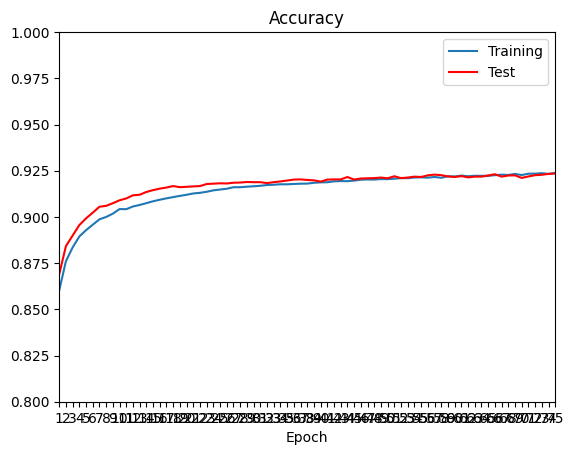

In [27]:
plt.figure(1)
plt.plot(torch.arange(1,nepochs+1), cost_hist, "-", label="Training")
plt.plot(torch.arange(1,nepochs+1), cost_hist_test, "r-", label="Test")
plt.xlabel("Epoch")
plt.xlim(1, nepochs)
plt.xticks(torch.arange(1, nepochs + 1))
plt.ylim(0, 1)
plt.title("Cross-Entropy Cost")
plt.legend()

plt.figure(2)
plt.plot(torch.arange(1,nepochs+1), acc_hist, "-", label="Training")
plt.plot(torch.arange(1,nepochs+1), acc_hist_test, "r-", label="Test")
plt.xlabel("Epoch")
plt.xlim(1, nepochs)
plt.xticks(torch.arange(1, nepochs + 1))
plt.ylim(0.8, 1)
plt.title("Accuracy")
plt.legend()